In [24]:
import sqlite3
import pandas as pd
from skimpy import skim
import numpy as np
import seaborn as sns
import missingno as msno
import re
from datetime import datetime
from collections import defaultdict
import math

In [25]:
# Connexion à la base de données SQLite
connexion = sqlite3.connect('/Users/f.b/Desktop/Data_Science/Clock_industry/Scripts/Data/montre.db')

# Exécution d'une requête SQL pour récupérer des données et conversion en DataFrame
df = pd.read_sql_query('SELECT * FROM montre', connexion)

# Fermeture de la connexion
connexion.close()

# Conversion de la base en format CSV 
df.to_csv('/Users/f.b/Desktop/Data_Science/Clock_industry/Scripts/Data/watches_database.csv')

# Chargement de la BDD sans la colonne id: 
df = df.iloc[:, 1:]

In [26]:
# Fonction de nettoyage pour chaque colonne
def nettoyer_colonnes(df, majuscule=True, remplacer_nan=np.nan) -> pd.DataFrame:
    for col in df.columns:
        # Supprimer les crochets et les apostrophes dans les chaînes de caractères
        df[col] = df[col].apply(lambda x: re.sub(r"[\[\]'\"()]", '', str(x)))
        
        # Supprimer les espaces multiples
        df[col] = df[col].apply(lambda x: re.sub(r'\s+', ' ', x).strip() if isinstance(x, str) else x)
     
    df = df.drop(columns='Date_recup')        
    df.drop_duplicates(inplace=True)
    
    colonnes = df.columns 
    
    for col in colonnes:
        # Remplacer les valeurs NaN par la valeur spécifiée
        df[col] = df[col].fillna(remplacer_nan)
        
        # Supprimer les espaces en début et en fin de chaîne
        df[col] = df[col].str.strip()
        
        # Convertir en majuscule ou minuscule selon le paramètre
        if majuscule:
            df[col] = df[col].str.upper()
        else:
            df[col] = df[col].str.lower()
    
    
    df = df.replace('', np.nan)
    df = df.replace('None', np.nan)
    
    return df

In [27]:
df = nettoyer_colonnes(df)

In [28]:
df.shape

(26746, 19)

In [29]:
df.head()

,marque,modele,mouvement,matiere_boitier,matiere_bracelet,annee_prod,etat,sexe,prix,reserve_de_marche,diametre,etencheite,matiere_lunette,matiere_verre,boucle,matiere_boucle,rouage,ville,fonctions
0,ROLEX,"DATEJUST, 36",AUTOMATIQUE,ACIER,ACIER,2011,"TRÈS, BON, TRACES, DUSURE, NULLES, OU, LÉGÈRES",HOMME/UNISEXE,"8, 700, £, =, 10, 437, €, PRIX, NÉGOCIABLE",NaN,"36, MM",NaN,ACIER,SAPHIR,PLIS,ACIER,NaN,"GRANDE-BRETAGNE,, LONDON",FONCTIONS DATE
1,"ZENO-WATCH, BASEL","X-LARGE, RETRO",AUTOMATIQUE,ACIER,MM,2023,"TRÈS, BON, TRACES, DUSURE, NULLES, OU, LÉGÈRES",HOMME/UNISEXE,"699, €","MARCHE, 42, H","44, X","3, ATM",ACIER,SAPHIR,"BOUCLE, ARDILLON",ACIER,2824-2,"ESPAGNE,, VALENCIA",FONCTIONS DATE
2,ROLEX,"YACHT-MASTER, 40",AUTOMATIQUE,OR/ACIER,OR/ACIER,2022,"TRÈS, BON, TRACES, DUSURE, NULLES, OU, LÉGÈRES",HOMME/UNISEXE,"89, 900, ZŁ, =, 21, 215, €, PRIX, NÉGOCIABLE","MARCHE, 70, H","40, MM","10, ATM",ROSE,SAPHIR,PLIS,"OR, ROSE",AUTOMATYCZNY,"POLOGNE,, WARSZAWA",FONCTIONS DATE
3,ROLEX,"DATEJUST, II",AUTOMATIQUE,ACIER,ACIER,2016,"TRÈS, BON, TRACES, DUSURE, NULLES, OU, LÉGÈRES",HOMME/UNISEXE,"8, 700, £, =, 10, 437, €",NaN,"41, MM",NaN,NaN,SAPHIR,PLIS,ACIER,NaN,"GRANDE-BRETAGNE,, BISHOPS, STORTFORD",FONCTIONS DATE
4,TUDOR,NaN,AUTOMATIQUE,NaN,ACIER,1975,"TRÈS, BON, TRACES, DUSURE, NULLES, OU, LÉGÈRES",HOMME/UNISEXE,"16, 500, €",NaN,"40, MM",NaN,ACIER,NaN,NaN,ACIER,7750,"BELGIQUE,, BRUXELLES","FONCTIONS CHRONOGRAPHE, DATE"


# Etude et traitement des valeurs manquantes :

In [30]:
# Suppression des lignes avec une faible proportion de données manquantes
df = df.dropna(subset=['marque','modele'])

marque                0.00
modele                0.00
mouvement             5.78
matiere_boitier       3.00
matiere_bracelet      3.61
annee_prod            0.00
etat                  0.13
sexe                  3.35
prix                  0.38
reserve_de_marche    34.89
diametre              3.20
etencheite           19.57
matiere_lunette      17.77
matiere_verre        17.65
boucle               13.46
matiere_boucle       10.96
rouage               23.71
ville                 0.39
fonctions            27.47
dtype: float64


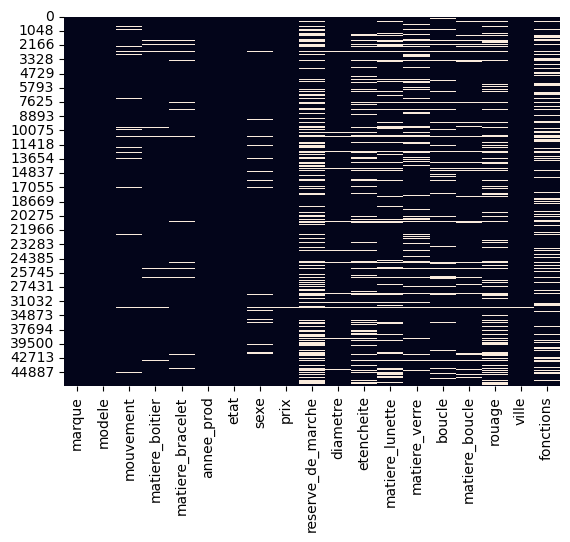

In [31]:
# Heatmap des valeurs manquantes
sns.heatmap(df.isnull(), cbar=False)

print(round(df.isnull().sum()/len(df)*100,2))


In [32]:
def remplissage(df, variable):
    # Grouper par 'marque', 'modele', 'mouvement' pour trouver les valeurs similaires
    groupes_similaires = df.groupby(['marque', 'modele', 'mouvement'])[variable]

    # Remplir les valeurs manquantes avec la première valeur non manquante des groupes similaires
    df[variable] = df[variable].fillna(groupes_similaires.transform('first'))

    return df

In [33]:
def remplissage_mouvement(df, variable):
    # Remplacer les listes vides par des NaN (si applicable, sinon cette étape peut être ignorée)
    df[variable] = df[variable].apply(lambda x: np.nan if isinstance(x, list) and not x else x)

    # Grouper par 'marque' et 'modele' pour trouver les valeurs similaires
    groupes_similaires = df.groupby(['marque', 'modele'])[variable]

    # Remplir les valeurs manquantes avec la première valeur non manquante des groupes similaires
    df[variable] = df[variable].fillna(groupes_similaires.transform('first'))

    return df

In [34]:
def remplissage_reserve_marche(df, variable):
    # Remplir 'Pas_de_reserve' pour les lignes où 'rouage' commence par 'Quar' ou 'ETA' et où 'variable' est NaN ou vide
    masque_quartz_eta = (
        (df[variable].isna() | (df[variable] == '')) &  # Si 'variable' est manquant ou vide
        df['rouage'].apply(lambda x: isinstance(x, str) and (x.startswith('Quar') or x.startswith('ETA')))  # Vérifier 'rouage'
    )
    df.loc[masque_quartz_eta, variable] = 'Pas_de_reserve'

    # Remplir 'Pas_de_reserve' pour les lignes où 'mouvement' est 'Quartz' et où 'variable' est NaN
    masque_quartz_mouvement = (df[variable].isna() | (df[variable] == '')) & (df['mouvement'] == 'Quartz')
    df.loc[masque_quartz_mouvement, variable] = 'Pas_de_reserve'

    return df

In [35]:
def suppression_colonnes(df):
    """Fonctions pour supprimer les colonnes inutiles"
    Args:
        df (pd.DataFarme): DataFrame contenant les colonnes à traiter. 
        liste_colonnes (list): Liste des colonnes à traiter.
    
    Returns: 
        pd.DataFrame : DataFrame modifié.  
    """
    colonnes_a_supp = ['rouage', 'fonctions']
    df = df.drop(columns=colonnes_a_supp)
    
    return df

In [36]:
def count_functions(fonction_series):
    # Remplacer les valeurs manquantes par 0
    fonction_series = fonction_series.fillna('')

    # Si 'Fonctions\n' est présent, extraire la partie après
    fonctions_mask = fonction_series.str.contains('FONCTIONS ')
    autres_mask = fonction_series.str.contains('AUTRES ')

    # Extraction et comptage pour 'Fonctions\n'
    fonction_counts = fonction_series[fonctions_mask].str.split('FONCTIONS ').str[1].str.split(',').apply(lambda x: len([func.strip() for func in x if func.strip()]))

    # Extraction et comptage pour 'Autres\n'
    autres_counts = fonction_series[autres_mask].str.split('AUTRES ').str[1].str.split(',').apply(lambda x: len([func.strip() for func in x if func.strip()]))

    # Remplir les résultats dans une nouvelle colonne
    result = pd.Series('Non_renseignée', index=fonction_series.index)

    # Ajouter les comptages de fonctions
    result.loc[fonctions_mask] = fonction_counts
    result.loc[autres_mask] = autres_counts

    # Remplacer les valeurs restantes par 0 si pas renseigné
    result = result.replace('', 0)

    return result

In [37]:
df = remplissage(df,'matiere_boitier')
df = remplissage(df,'matiere_bracelet')
df = remplissage(df,'sexe')
df = remplissage(df, 'diametre')
df = remplissage(df,'etencheite')
df = remplissage(df, 'matiere_lunette')
df = remplissage(df, 'matiere_verre')
df = remplissage(df,'boucle')
df = remplissage(df,'matiere_boucle')
df = remplissage(df,'rouage')
df = remplissage(df, 'reserve_de_marche')
df = remplissage_mouvement(df, 'mouvement')
df = remplissage_reserve_marche(df, 'reserve_de_marche')
df['nbre_complications'] = count_functions(df['fonctions'])
df = suppression_colonnes(df)

# Traitement de la variable *Marque* : 

In [38]:
marque = [i.replace(', ', '-').replace('.','') for i in df['marque']]
df['marque'] = marque

# Traitement de la variable *Modele* : 

In [39]:
modele = [i.replace(',','').replace(' ','-') for i in df['modele']]
df['modele'] = modele

# Traitement de la variable *Mouvement* : 

In [40]:
mapping = {"FOND, TRANSPARENT,, INDICATION, DE, LA, RÉSERVE, DE, MARCHE,, ÉTAT, DORIGINE/PIÈCES, ORIGINALES,, COUCHE, PVD/DLC" : "AUTOMATIQUE",
           
    "28000, A/H": "AUTOMATIQUE",
           "REMONTAGE, AUTOMATIQUE": "AUTOMATIQUE",
           "REMONTAGE, MANUEL" : "AUTOMATIQUE",
           "21600, A/H" : "AUTOMATIQUE",
           "REMONTAGE AUTOMATIQUE" : "AUTOMATIQUE",
           "MONTRE, CONNECTÉE" : "BATTERIE",
           "SQUELETTE" : "AUTOMATIQUE"
           } 
           
           
df['mouvement'] = df['mouvement'].replace(mapping)

In [42]:
df = df.replace('None', np.nan)

# Traitement de la variable *Matiere_bracelet*

In [44]:
# Liste des matières identifiées
matières = ["acier", "or/acier", "cuir", "textile", "titane", "caoutchouc", "bronze",
            "silicone", "vache", "autruche", "bronze","plastique", "platine", "céramique","or",
            "aluminium", "argentt", "requin", "caoutchouc", "plastique", "silicone", 
            "céramique", "satin"]

def extraire_matière(chaine):
    if isinstance(chaine, str):  # Vérifier si la chaîne est une chaîne de caractères
        for matiere in matières:
            if matiere.lower() in chaine.lower():
                return matiere.upper()
    return 'INCONNUE'

In [45]:
matiere_bracelet = [extraire_matière(chaine) for chaine in df['matiere_bracelet']]
df['matiere_bracelet'] = matiere_bracelet

# Traitement de la variable *Matiere_boitier* 

In [47]:
def nettoyer_matiere_boitier(chaine):
    if isinstance(chaine, str):  # Vérifier si la variable est une chaîne
        # Remplacer les barres obliques par des virgules avec espaces
        chaine = chaine.replace("/", ", ")
        # Nettoyer les virgules en trop
        chaine = re.sub(r'\s*,\s*', ', ', chaine)
        # Supprimer les espaces au début et à la fin
        chaine = chaine.strip()
        # Remplacer les virgules et espaces par des underscores
        chaine = chaine.replace(', ', '_')
        return chaine
    else:
        return 'INCONNUE'  # Retourner 'INCONNUE' si ce n'est pas une chaîne

In [48]:
df['matiere_boitier'] = [nettoyer_matiere_boitier(chaine) for chaine in df['matiere_boitier']]

# Traitement de la variable annee_prod 

In [50]:
# Fonction pour extraire les années (format AAAA)
def extract_year(valeur):
    # Utiliser une regex pour chercher un nombre à 4 chiffres (une année)
    match = re.search(r'\b(19|20)\d{2}\b', str(valeur))
    if match:
        return match.group(0)  # Si une année est trouvée, la retourner
    else:
        return None  # Si aucune année n'est trouvée

# Appliquer la fonction à la liste de données
annee_prod = [extract_year(valeur) for valeur in df['annee_prod']]
df['annee_prod'] = annee_prod

# Traitement de la variable Etat

In [53]:
# Dictionnaire de correspondance entre les états et des catégories restreintes
catégories_état = {
    "neuf": "Neuf",
    "jamais porté": "Neuf",
    "usure nulle": "Neuf",
    "aucune trace d'usure": "Neuf",
    "bon": "Bon",
    "légères traces d'usure": "Bon",
    "traces d'usure visibles": "Satisfaisant",
    "modéré": "Satisfaisant",
    "satisfaisant": "Satisfaisant",
    "fortement usagé": "Usé",
    "traces d'usure importantes": "Usé",
    "défectueux": "Défectueux",
    "incomplet": "Défectueux",
    "pas fonctionnelle": "Défectueux"
}

# Fonction pour regrouper l'état d'une chaîne dans une catégorie restreinte
def regrouper_état(chaine):
    if isinstance(chaine, str):  # Vérifier si la chaîne est bien une chaîne de caractères
        chaine = chaine.lower()  # Convertir la chaîne en minuscule
        états_trouvés = []
        
        # Chercher les mots-clés de l'état dans la chaîne
        for mot_clé, catégorie in catégories_état.items():
            if mot_clé in chaine:
                états_trouvés.append(catégorie)  # Ajouter la catégorie correspondante
        
        if états_trouvés:
            # Retourner la catégorie la plus représentative (par exemple, la plus courante)
            return max(set(états_trouvés), key=états_trouvés.count)
        else:
            return 'État non spécifié'
    else:
        return 'État non spécifié'  # Retourner "État non spécifié" si ce n'est pas une chaîne de caractères


# Appliquer la fonction pour regrouper les caractéristiques de l'état
df['etat'] = [regrouper_état(chaine) for chaine in df['etat']]

# Traitement de la variable sexe 

In [59]:
mapping = {"HOMME/UNISEXE":"HOMME",
           "MONTRE HOMME/UNISEXE":"HOMME",
           "MONTRE, FEMME":"FEMME",
           "MONTRE, HOMME/UNISEXE":"HOMME"  
}

df['sexe'] = df['sexe'].replace(mapping)

# Traitement de la variable prix :

In [61]:
def extraire_elements_avant_euro(chaine):
    if isinstance(chaine, str):  # Vérifier si la chaîne est bien de type string
        # Nettoyer la chaîne en la divisant en mots
        elements = re.split(r'[,\s]+', chaine.strip())  # Séparer par virgules et espaces

        # Initialiser une liste vide pour les résultats
        sous_liste = []
        
        # Rechercher la position de '€' dans la liste
        if '€' in elements:
            index_fin = elements.index('€')  # Trouver l'index du symbole €
            
            # Extraire les deux éléments précédant '€' s'ils existent
            if index_fin >= 2:
                sous_liste = elements[index_fin-2:index_fin]  # Extraire les 2 éléments avant '€'
            else:
                sous_liste = elements[:index_fin]  # Si moins de 2 éléments avant, extraire jusqu'à '€'
        
        return sous_liste
    else:
        return []  # Retourner une liste vide si l'entrée n'est pas une chaîne

In [62]:
def nettoyer_valeurs(valeurs):
    valeurs_nettoyees = []
    
    for val in valeurs:
        # Joindre les éléments de la liste (qui sont les parties du nombre)
        nombre_str = ''.join(val)
        
        # Vérifier que la chaîne n'est pas vide avant de procéder
        if nombre_str.strip():  # Vérifier que ce n'est pas une chaîne vide
            try:
                # Convertir en entier
                nombre = int(nombre_str)
            except ValueError:
                # Si la conversion en entier échoue, tenter avec float
                try:
                    nombre = float(nombre_str)
                except ValueError:
                    # Si la conversion échoue encore, ajouter None (ou gérer comme vous voulez)
                    nombre = None
        else:
            # Si la chaîne est vide, ajouter None (ou une valeur par défaut)
            nombre = None
        
        valeurs_nettoyees.append(nombre)
    
    return valeurs_nettoyees

In [63]:
prix = [extraire_elements_avant_euro(chaine) for chaine in df['prix']]
prix = nettoyer_valeurs(prix)
df['prix'] = prix

# Traitement de la variable réserve de marche 

In [64]:
def extraire_chiffre(chaine):
    if pd.isna(chaine):  # Vérifier si la chaîne est None ou NaN
        return None
    # Rechercher tous les nombres dans la chaîne
    match = re.search(r'\d+', chaine)
    if match:
        return int(match.group())  # Retourner le premier nombre trouvé sous forme d'entier
    return None 

reserve_de_marche = [extraire_chiffre(chaine) for chaine in df['reserve_de_marche']]
df['reserve_de_marche'] = reserve_de_marche

# Traitement de la variable diametre 

In [67]:
diametre = [extraire_chiffre(chaine) for chaine in df['diametre']]
df['diametre'] = diametre

# Traitement de la varaible etencheite 

In [70]:
etencheite = [extraire_chiffre(chaine) for chaine in df['etencheite']]
df['etencheite'] = etencheite

# Traitement de la variable matiere_lunette

In [72]:
# Liste des matières à rechercher
matières = ['ACIER', 'ROSE', 'JAUNE', 'CÉRAMIQUE', 'TITANE', 'BRONZE',
            'ALUMINIUM', 'BLANC', 'PLATINE', 'OR/ACIER', 'ARGENT', 'PLASTIQUE',
            'TUNGSTÈNE', 'ROUGE', 'CARBONE', 'OR', 'OR, BLANC', 'OR, ROSE', 'OR, JAUNE', 'PLAQUÉE, OR', 
            'CÉRAMIQUE, FONCÉE', 'LUNETTE, LISSE', 'OR, ROUGE']


def extraire_matière(chaine):
    if pd.isna(chaine):  # Vérifier si la chaîne est None ou NaN
        return None
    
    # Mettre la chaîne en majuscules pour faciliter la recherche
    chaine = chaine.upper()
    
    # Rechercher chaque matière dans la chaîne
    for matiere in matières:
        if matiere in chaine:
            return matiere  # Retourner la première matière trouvée
    
    return None 

matiere_lunette = [extraire_matière(chaine) for chaine in df['matiere_lunette']]

In [73]:
df['matiere_lunette'] = matiere_lunette

In [74]:
df['matiere_lunette'].unique()

array(['ACIER', 'ROSE', 'JAUNE', 'CÉRAMIQUE', 'TITANE', 'BRONZE',
       'ALUMINIUM', None, 'BLANC', 'PLATINE', 'ARGENT', 'PLASTIQUE',
       'TUNGSTÈNE', 'ROUGE', 'CARBONE', 'OR', 'LUNETTE, LISSE'],
      dtype=object)

# Traitement de la variable matiere_verre

In [78]:
df.matiere_verre.unique()

array(['SAPHIR', 'MINÉRAL', nan, None, 'PLASTIQUE', 'PLEXIGLAS', 'VERRE'],
      dtype=object)

In [79]:
mapping = {
    'VERRE SAPHIR' : 'SAPHIR',
    'VERRE, MINÉRAL' : 'MINÉRAL',
    'MATIÈRE, PLASTIQUE':'PLASTIQUE',
    'VERRE, SAPHIR':'SAPHIR'
}

df['matiere_verre'] = df['matiere_verre'].replace(mapping)

# Traitement de la variable boucle 

In [80]:
df['boucle'] = df['boucle'].str.replace(', ','_')

# Traitement de la variable matiere_boucle

In [83]:
# Liste des matières à rechercher
matieres = ['ACIER', 'OR, ROSE', 'OR, JAUNE', 'CÉRAMIQUE', 'TITANE', 'BRONZE',
            'ALUMINIUM', 'OR, BLANC', 'PLATINE', 'OR/ACIER', 'ARGENT',
            'MATIÈRE, PLASTIQUE', 'PLASTIQUE', None, 'TUNGSTÈNE', 'OR, ROUGE',
            'CARBONE', 'PLAQUÉE, OR']

matiere_boucle = [extraire_matière(chaine) for chaine in df['matiere_boucle']]
df['matiere_boucle'] = matiere_boucle

# Traitement de la variable ville 

In [85]:
pays = [i.split(',')[0].strip() if isinstance(i, str) else 'INCONNU' for i in df['ville']]
df = df.drop(columns=['ville'])
df['pays'] = pays

In [86]:
mapping = {
    'AFRIQUE': 'AFRIQUE_DU_SUD',
    'RÉPUBLIQUE' : 'RÉPUBLIQUE_TCHEQUE',
    'HONG' : 'HONG_KONG',
    'VIÊT' : 'VIETNAM',
    'PORTO' : 'PORTUGAL',
    'E.A.U.' : 'EMIRAT_ARABE_UNIS',
    'SRI': 'SRI_LANKA',
    'ARABIE' : 'ARABIE_SAOUDITE' 
}

df['pays'] = df['pays'].replace(mapping)

# Sauvegarde la BDD nettoyée :

In [238]:
df.to_csv('/Users/f.b/Desktop/Data_Science/Clock_industry/Scripts/Data/data_clean.csv')